# Predictive Analytics: Trigger Word Detector

**Model 5**: Identify words/phrases that trigger strong emotional responses in Trump's speeches

This notebook analyzes:
- Which words appear most often in high-emotion speech segments
- Co-occurrence of words with specific emotions (anger, joy, fear, etc.)
- "Trigger scores" for each word based on emotional intensity

**Output**: A model that predicts if a word/phrase will trigger a strong emotional response.


In [1]:
import pandas as pd
import numpy as np
import json
import re
from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries loaded!")


✓ Libraries loaded!


## 1. Load Data


In [2]:
# Load cleaned speeches
cleaned_dir = Path('../data/cleaned')
cleaned_files = list(cleaned_dir.glob('speeches_cleaned_*.json'))

if cleaned_files:
    latest_cleaned = max(cleaned_files, key=lambda p: p.stat().st_mtime)
    with open(latest_cleaned, 'r', encoding='utf-8') as f:
        speeches = json.load(f)
    print(f"✓ Loaded {len(speeches)} speeches")
else:
    raise FileNotFoundError("No cleaned speech files found!")

# Extract all text
all_texts = []
for speech in speeches:
    text = speech.get('cleaned_text', speech.get('text', ''))
    if text:
        all_texts.append({
            'speech_id': speech.get('speech_id', ''),
            'title': speech.get('title', ''),
            'date': speech.get('date', ''),
            'text': text
        })

print(f"✓ Extracted text from {len(all_texts)} speeches")
print(f"  Total words: {sum(len(t['text'].split()) for t in all_texts):,}")


✓ Loaded 43 speeches
✓ Extracted text from 43 speeches
  Total words: 350,591


## 2. Define Emotion Lexicon

We'll use keyword-based emotion detection to score each text segment.


In [3]:
# Comprehensive emotion lexicon
EMOTION_LEXICON = {
    'anger': [
        'angry', 'furious', 'outraged', 'mad', 'hate', 'hatred', 'rage', 'hostile',
        'bitter', 'resentment', 'disgrace', 'terrible', 'horrible', 'disaster',
        'corrupt', 'crooked', 'liar', 'liars', 'enemy', 'enemies', 'destroy',
        'destroyed', 'attack', 'attacked', 'fight', 'fought', 'war', 'kill',
        'stupid', 'idiot', 'fool', 'incompetent', 'weak', 'pathetic', 'disgraceful',
        'shameful', 'outrageous', 'unacceptable', 'ridiculous', 'insane', 'crazy'
    ],
    'fear': [
        'afraid', 'scared', 'fear', 'terror', 'threat', 'danger', 'dangerous',
        'risk', 'worry', 'worried', 'anxious', 'panic', 'horror', 'dread',
        'invasion', 'crime', 'criminal', 'criminals', 'violence', 'violent',
        'terrorist', 'terrorists', 'attack', 'nuclear', 'weapons', 'death'
    ],
    'joy': [
        'happy', 'joy', 'love', 'wonderful', 'great', 'amazing', 'fantastic',
        'beautiful', 'excellent', 'incredible', 'tremendous', 'success', 'successful',
        'win', 'won', 'winner', 'winners', 'best', 'proud', 'celebrate', 'celebration',
        'exciting', 'thrilled', 'delighted', 'pleased', 'grateful', 'blessed'
    ],
    'sadness': [
        'sad', 'sorry', 'loss', 'lost', 'tragic', 'tragedy', 'unfortunate',
        'disappointed', 'disappointment', 'grief', 'misery', 'suffering', 'pain',
        'hurt', 'heartbreaking', 'devastating', 'terrible', 'awful'
    ],
    'disgust': [
        'disgusting', 'disgrace', 'shameful', 'shame', 'pathetic', 'weak',
        'loser', 'losers', 'fake', 'fraud', 'scam', 'corrupt', 'corruption',
        'swamp', 'drain', 'nasty', 'horrible', 'terrible', 'worst', 'sick',
        'disgusted', 'appalling', 'repulsive', 'vile'
    ],
    'surprise': [
        'surprised', 'shocking', 'shocked', 'unexpected', 'amazing', 'incredible',
        'unbelievable', 'stunning', 'astonishing', 'remarkable', 'wow'
    ],
    'trust': [
        'trust', 'believe', 'faith', 'honest', 'true', 'truth', 'loyal', 'loyalty',
        'reliable', 'dependable', 'promise', 'commitment', 'dedicated', 'patriot',
        'america', 'american', 'americans', 'country', 'nation', 'freedom', 'liberty'
    ],
    'anticipation': [
        'will', 'going', 'plan', 'future', 'hope', 'expect', 'forward',
        'soon', 'tomorrow', 'next', 'coming', 'goal', 'goals', 'agenda'
    ]
}

# Create reverse lookup: word -> emotions
WORD_TO_EMOTIONS = defaultdict(list)
for emotion, words in EMOTION_LEXICON.items():
    for word in words:
        WORD_TO_EMOTIONS[word].append(emotion)

print(f"✓ Emotion lexicon loaded: {sum(len(w) for w in EMOTION_LEXICON.values())} keywords across {len(EMOTION_LEXICON)} emotions")


✓ Emotion lexicon loaded: 182 keywords across 8 emotions


## 3. Segment Speeches & Compute Emotion Scores

Split each speech into sentences, then compute emotion intensity for each segment.


In [4]:
def split_into_sentences(text):
    """Split text into sentences."""
    # Simple sentence splitting on . ! ?
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return [s.strip() for s in sentences if len(s.strip()) > 10]

def compute_segment_emotions(text):
    """Compute emotion scores for a text segment."""
    text_lower = text.lower()
    words = re.findall(r'\b\w+\b', text_lower)
    word_count = len(words)
    
    if word_count == 0:
        return {'total_intensity': 0, 'emotions': {}}
    
    scores = {}
    for emotion, keywords in EMOTION_LEXICON.items():
        count = sum(1 for w in words if w in keywords)
        scores[emotion] = count
    
    total_intensity = sum(scores.values())
    
    return {
        'total_intensity': total_intensity,
        'intensity_per_word': total_intensity / word_count if word_count > 0 else 0,
        'emotions': scores,
        'word_count': word_count
    }

# Test
test_sentence = "This is a terrible disaster, I hate what they did, it's disgraceful!"
test_result = compute_segment_emotions(test_sentence)
print(f"Test: '{test_sentence}'")
print(f"  Total intensity: {test_result['total_intensity']}")
print(f"  Emotions: {test_result['emotions']}")


Test: 'This is a terrible disaster, I hate what they did, it's disgraceful!'
  Total intensity: 6
  Emotions: {'anger': 4, 'fear': 0, 'joy': 0, 'sadness': 1, 'disgust': 1, 'surprise': 0, 'trust': 0, 'anticipation': 0}


In [5]:
# Process all speeches into segments with emotion scores
print("Processing speeches into segments...")

all_segments = []
for speech_data in all_texts:
    sentences = split_into_sentences(speech_data['text'])
    
    for sent in sentences:
        emotion_data = compute_segment_emotions(sent)
        
        # Extract words from this segment
        words = re.findall(r'\b[a-zA-Z]{3,}\b', sent.lower())  # 3+ letter words only
        
        all_segments.append({
            'speech_id': speech_data['speech_id'],
            'text': sent,
            'words': words,
            'word_count': len(words),
            'total_intensity': emotion_data['total_intensity'],
            'intensity_per_word': emotion_data['intensity_per_word'],
            **{f'emotion_{k}': v for k, v in emotion_data['emotions'].items()}
        })

df_segments = pd.DataFrame(all_segments)
print(f"\n✓ Created {len(df_segments)} segments from {len(all_texts)} speeches")
print(f"  Avg words per segment: {df_segments['word_count'].mean():.1f}")
print(f"  Avg emotion intensity: {df_segments['total_intensity'].mean():.2f}")

# Show intensity distribution
print(f"\nIntensity distribution:")
print(f"  Min: {df_segments['total_intensity'].min()}")
print(f"  Max: {df_segments['total_intensity'].max()}")
print(f"  Median: {df_segments['total_intensity'].median()}")
print(f"  90th percentile: {df_segments['total_intensity'].quantile(0.9)}")


Processing speeches into segments...

✓ Created 27875 segments from 43 speeches
  Avg words per segment: 9.4
  Avg emotion intensity: 0.49

Intensity distribution:
  Min: 0
  Max: 13
  Median: 0.0
  90th percentile: 2.0


## 4. Compute Trigger Scores for Each Word

For each unique word, compute:
- **Trigger Score**: How often it appears in high-emotion segments vs low-emotion segments
- **Emotion Profile**: Which emotions it co-occurs with most
- **Intensity Lift**: How much the word "lifts" emotional intensity above baseline


In [6]:
# Define high-emotion threshold (top 25% of segments)
HIGH_EMOTION_THRESHOLD = df_segments['total_intensity'].quantile(0.75)
print(f"High-emotion threshold: {HIGH_EMOTION_THRESHOLD} (top 25% of segments)")

# Label segments as high/low emotion
df_segments['is_high_emotion'] = df_segments['total_intensity'] >= HIGH_EMOTION_THRESHOLD

print(f"High-emotion segments: {df_segments['is_high_emotion'].sum()} ({df_segments['is_high_emotion'].mean():.1%})")
print(f"Low-emotion segments: {(~df_segments['is_high_emotion']).sum()}")


High-emotion threshold: 1.0 (top 25% of segments)
High-emotion segments: 9248 (33.2%)
Low-emotion segments: 18627


In [7]:
# Compute trigger score for each word
print("Computing trigger scores for all words...")

# Build word statistics
word_stats = defaultdict(lambda: {
    'total_count': 0,
    'high_emotion_count': 0,
    'low_emotion_count': 0,
    'total_intensity_sum': 0,
    'emotion_counts': defaultdict(int),
    'segments': []
})

# Global baseline intensity
BASELINE_INTENSITY = df_segments['total_intensity'].mean()

# Process each segment
for idx, row in df_segments.iterrows():
    for word in row['words']:
        stats = word_stats[word]
        stats['total_count'] += 1
        stats['total_intensity_sum'] += row['total_intensity']
        stats['segments'].append(idx)
        
        if row['is_high_emotion']:
            stats['high_emotion_count'] += 1
        else:
            stats['low_emotion_count'] += 1
        
        # Track which emotions this word co-occurs with
        for emotion in EMOTION_LEXICON.keys():
            stats['emotion_counts'][emotion] += row.get(f'emotion_{emotion}', 0)

print(f"✓ Analyzed {len(word_stats)} unique words")


Computing trigger scores for all words...
✓ Analyzed 9708 unique words


In [8]:
# Calculate trigger scores
MIN_OCCURRENCES = 10  # Filter out rare words

trigger_data = []
for word, stats in word_stats.items():
    if stats['total_count'] < MIN_OCCURRENCES:
        continue
    
    # Trigger score: ratio of high-emotion to total occurrences
    high_emotion_ratio = stats['high_emotion_count'] / stats['total_count']
    
    # Intensity lift: average intensity when word appears vs baseline
    avg_intensity = stats['total_intensity_sum'] / stats['total_count']
    intensity_lift = avg_intensity - BASELINE_INTENSITY
    
    # Find dominant emotion for this word
    emotion_totals = dict(stats['emotion_counts'])
    if sum(emotion_totals.values()) > 0:
        dominant_emotion = max(emotion_totals, key=emotion_totals.get)
        dominant_emotion_score = emotion_totals[dominant_emotion]
    else:
        dominant_emotion = 'none'
        dominant_emotion_score = 0
    
    # Compute negative emotion ratio
    negative_emotions = ['anger', 'fear', 'disgust', 'sadness']
    positive_emotions = ['joy', 'trust']
    
    neg_sum = sum(emotion_totals.get(e, 0) for e in negative_emotions)
    pos_sum = sum(emotion_totals.get(e, 0) for e in positive_emotions)
    total_emo = neg_sum + pos_sum
    negative_ratio = neg_sum / total_emo if total_emo > 0 else 0.5
    
    trigger_data.append({
        'word': word,
        'total_count': stats['total_count'],
        'high_emotion_count': stats['high_emotion_count'],
        'high_emotion_ratio': high_emotion_ratio,
        'avg_intensity': avg_intensity,
        'intensity_lift': intensity_lift,
        'dominant_emotion': dominant_emotion,
        'dominant_emotion_score': dominant_emotion_score,
        'negative_ratio': negative_ratio,
        # Individual emotion scores (normalized)
        **{f'emo_{k}': v / stats['total_count'] for k, v in emotion_totals.items()}
    })

df_triggers = pd.DataFrame(trigger_data)

# Compute composite TRIGGER SCORE (0-100)
# Combines: high_emotion_ratio, intensity_lift, negative_ratio
df_triggers['trigger_score'] = (
    df_triggers['high_emotion_ratio'] * 40 +  # 40% weight on high-emotion frequency
    (df_triggers['intensity_lift'] / df_triggers['intensity_lift'].max()) * 30 +  # 30% on intensity lift
    df_triggers['negative_ratio'] * 30  # 30% on negative emotion presence
) * 100 / 100  # Normalize to 0-100

# Clip to 0-100
df_triggers['trigger_score'] = df_triggers['trigger_score'].clip(0, 100)

print(f"✓ Computed trigger scores for {len(df_triggers)} words (min {MIN_OCCURRENCES} occurrences)")
print(f"\nTrigger score range: {df_triggers['trigger_score'].min():.1f} - {df_triggers['trigger_score'].max():.1f}")


✓ Computed trigger scores for 2186 words (min 10 occurrences)

Trigger score range: 0.0 - 99.3


## 5. Top Trigger Words

Identify the words that most strongly trigger emotional responses.


In [9]:
# Top trigger words overall
print("=" * 70)
print("🔥 TOP 25 TRIGGER WORDS (Highest Emotional Response)")
print("=" * 70)

top_triggers = df_triggers.nlargest(25, 'trigger_score')[
    ['word', 'trigger_score', 'total_count', 'high_emotion_ratio', 'dominant_emotion', 'negative_ratio']
]

for i, (_, row) in enumerate(top_triggers.iterrows(), 1):
    bar = "█" * int(row['trigger_score'] / 5)
    print(f"{i:2}. {row['word']:15} | Score: {row['trigger_score']:5.1f} | {bar}")
    print(f"    Occurrences: {row['total_count']:4} | High-emo: {row['high_emotion_ratio']:.0%} | Negative: {row['negative_ratio']:.0%} | Emotion: {row['dominant_emotion']}")
    print()


🔥 TOP 25 TRIGGER WORDS (Highest Emotional Response)
 1. terrible        | Score:  99.3 | ███████████████████
    Occurrences:  115 | High-emo: 100% | Negative: 98% | Emotion: anger

 2. corrupt         | Score:  95.9 | ███████████████████
    Occurrences:   28 | High-emo: 100% | Negative: 94% | Emotion: anger

 3. horrible        | Score:  90.1 | ██████████████████
    Occurrences:   88 | High-emo: 100% | Negative: 94% | Emotion: anger

 4. attack          | Score:  89.7 | █████████████████
    Occurrences:   49 | High-emo: 100% | Negative: 95% | Emotion: fear

 5. weak            | Score:  85.9 | █████████████████
    Occurrences:   12 | High-emo: 100% | Negative: 90% | Emotion: anger

 6. crooked         | Score:  84.5 | ████████████████
    Occurrences:   13 | High-emo: 100% | Negative: 100% | Emotion: anger

 7. suffering       | Score:  84.0 | ████████████████
    Occurrences:   10 | High-emo: 100% | Negative: 77% | Emotion: sadness

 8. terrorists      | Score:  83.7 | ██████████

In [10]:
# Top NEGATIVE trigger words (high negative emotion ratio)
print("=" * 70)
print("🔴 TOP 15 NEGATIVE TRIGGER WORDS (Anger/Fear/Disgust)")
print("=" * 70)

negative_triggers = df_triggers[df_triggers['negative_ratio'] > 0.4].nlargest(15, 'trigger_score')
for i, (_, row) in enumerate(negative_triggers.iterrows(), 1):
    print(f"{i:2}. {row['word']:15} | Score: {row['trigger_score']:5.1f} | Negative: {row['negative_ratio']:.0%} | Emotion: {row['dominant_emotion']}")

print("\n")
print("=" * 70)
print("🟢 TOP 15 POSITIVE TRIGGER WORDS (Joy/Trust)")
print("=" * 70)

positive_triggers = df_triggers[df_triggers['negative_ratio'] < 0.35].nlargest(15, 'trigger_score')
for i, (_, row) in enumerate(positive_triggers.iterrows(), 1):
    print(f"{i:2}. {row['word']:15} | Score: {row['trigger_score']:5.1f} | Positive: {1-row['negative_ratio']:.0%} | Emotion: {row['dominant_emotion']}")


🔴 TOP 15 NEGATIVE TRIGGER WORDS (Anger/Fear/Disgust)
 1. terrible        | Score:  99.3 | Negative: 98% | Emotion: anger
 2. corrupt         | Score:  95.9 | Negative: 94% | Emotion: anger
 3. horrible        | Score:  90.1 | Negative: 94% | Emotion: anger
 4. attack          | Score:  89.7 | Negative: 95% | Emotion: fear
 5. weak            | Score:  85.9 | Negative: 90% | Emotion: anger
 6. crooked         | Score:  84.5 | Negative: 100% | Emotion: anger
 7. suffering       | Score:  84.0 | Negative: 77% | Emotion: sadness
 8. terrorists      | Score:  83.7 | Negative: 89% | Emotion: fear
 9. danger          | Score:  83.7 | Negative: 68% | Emotion: fear
10. fight           | Score:  82.9 | Negative: 79% | Emotion: anger
11. weapons         | Score:  82.0 | Negative: 95% | Emotion: fear
12. nuclear         | Score:  81.7 | Negative: 91% | Emotion: fear
13. violent         | Score:  81.4 | Negative: 94% | Emotion: fear
14. kill            | Score:  81.4 | Negative: 87% | Emotion: ange

## 6. Visualizations


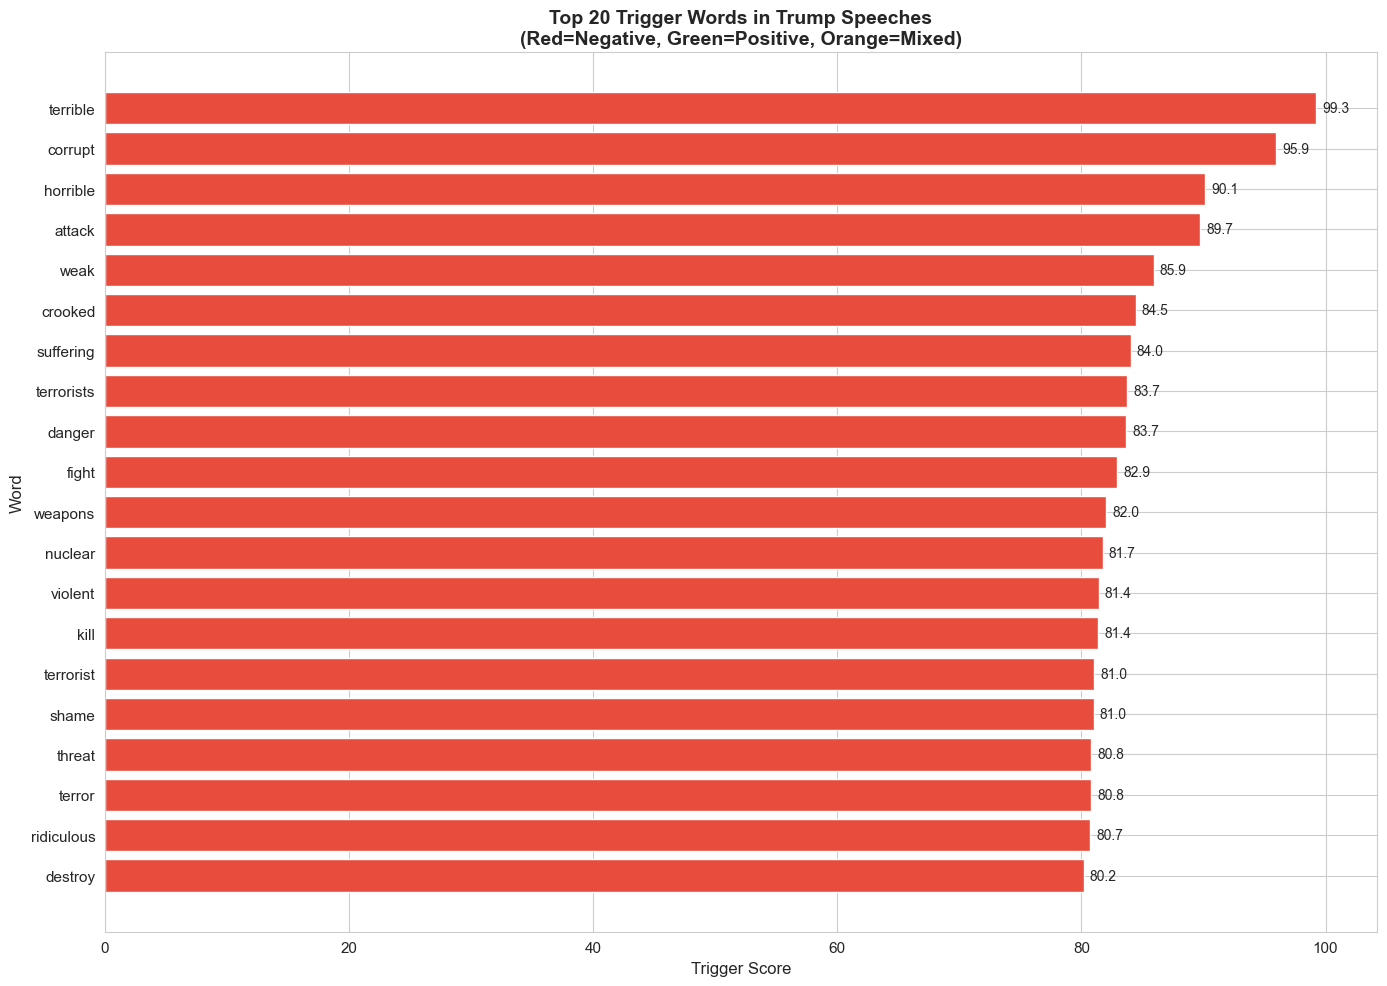

Saved: documentation/diagrams/trigger_words_top20.png


In [11]:
# Bar chart: Top 20 trigger words
fig, ax = plt.subplots(figsize=(14, 10))

top20 = df_triggers.nlargest(20, 'trigger_score')

# Color by negative ratio (red = negative, green = positive)
colors = ['#e74c3c' if r > 0.4 else '#27ae60' if r < 0.35 else '#f39c12' 
          for r in top20['negative_ratio']]

bars = ax.barh(top20['word'], top20['trigger_score'], color=colors)
ax.set_xlabel('Trigger Score', fontsize=12)
ax.set_ylabel('Word', fontsize=12)
ax.set_title('Top 20 Trigger Words in Trump Speeches\n(Red=Negative, Green=Positive, Orange=Mixed)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, score in zip(bars, top20['trigger_score']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{score:.1f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../documentation/diagrams/trigger_words_top20.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: documentation/diagrams/trigger_words_top20.png")


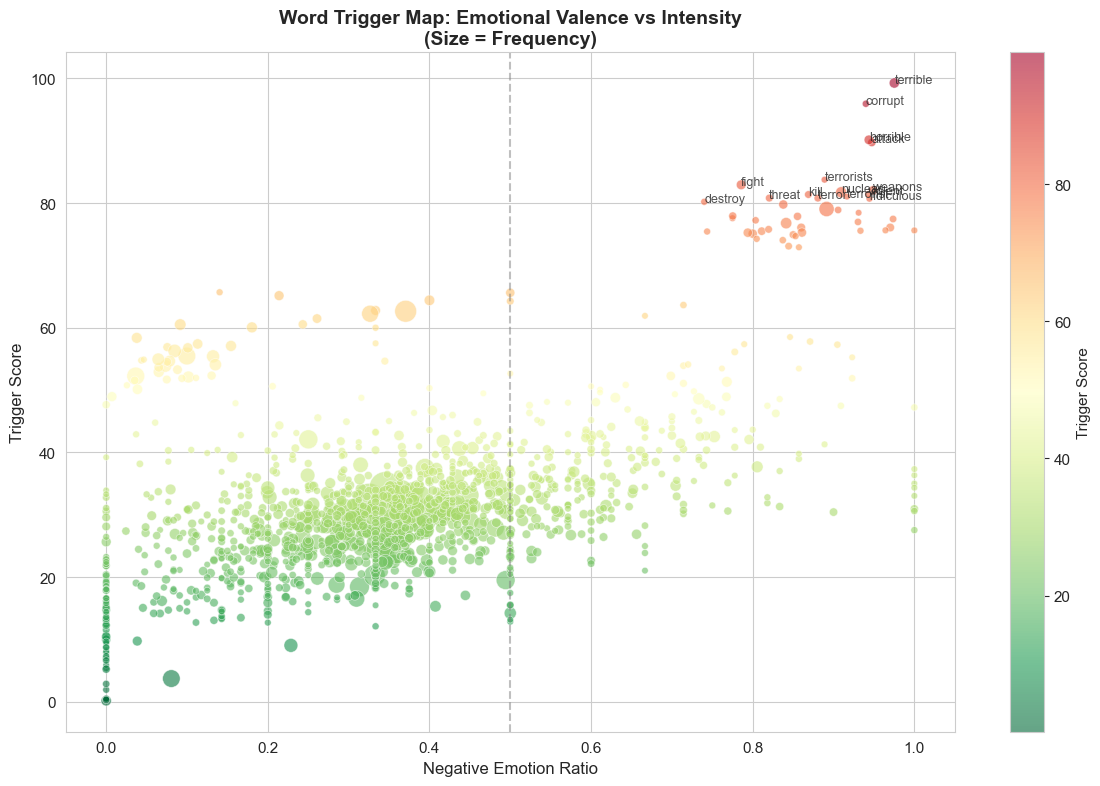

Saved: documentation/diagrams/trigger_words_scatter.png


In [12]:
# Scatter: Trigger Score vs Negative Ratio
fig, ax = plt.subplots(figsize=(12, 8))

# Filter to words with significant counts
df_plot = df_triggers[df_triggers['total_count'] >= 20].copy()

# Size by frequency
sizes = np.sqrt(df_plot['total_count']) * 5

scatter = ax.scatter(df_plot['negative_ratio'], df_plot['trigger_score'], 
                     s=sizes, c=df_plot['trigger_score'], cmap='RdYlGn_r',
                     alpha=0.6, edgecolors='white', linewidth=0.5)

# Annotate top words
for _, row in df_plot.nlargest(15, 'trigger_score').iterrows():
    ax.annotate(row['word'], (row['negative_ratio'], row['trigger_score']),
                fontsize=9, alpha=0.8)

ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Neutral line')
ax.set_xlabel('Negative Emotion Ratio', fontsize=12)
ax.set_ylabel('Trigger Score', fontsize=12)
ax.set_title('Word Trigger Map: Emotional Valence vs Intensity\n(Size = Frequency)', 
             fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Trigger Score')
plt.tight_layout()
plt.savefig('../documentation/diagrams/trigger_words_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: documentation/diagrams/trigger_words_scatter.png")


## 7. Trigger Word Predictor Function

Input any word/phrase and predict if it will trigger an emotional response.


In [13]:
# Create lookup dictionary for fast prediction
trigger_lookup = df_triggers.set_index('word').to_dict('index')

def predict_trigger(word_or_phrase):
    """
    🎯 PREDICTIVE MODEL: Predict if a word/phrase will trigger emotional response.
    
    Args:
        word_or_phrase: Any word or phrase to test
    
    Returns:
        Dictionary with trigger prediction
    """
    # Normalize input
    words = re.findall(r'\b[a-zA-Z]{3,}\b', word_or_phrase.lower())
    
    if not words:
        return {
            'input': word_or_phrase,
            'status': 'INVALID',
            'message': 'No valid words found (need 3+ letter words)'
        }
    
    # Check each word
    found_words = []
    not_found = []
    
    for word in words:
        if word in trigger_lookup:
            found_words.append((word, trigger_lookup[word]))
        else:
            not_found.append(word)
    
    if not found_words:
        return {
            'input': word_or_phrase,
            'words_checked': words,
            'status': 'NOT_FOUND',
            'message': f"No data for these words. They may not appear often in Trump speeches."
        }
    
    # Aggregate scores for multi-word input
    total_score = sum(data['trigger_score'] for _, data in found_words)
    avg_score = total_score / len(found_words)
    max_score = max(data['trigger_score'] for _, data in found_words)
    
    # Find most triggering word
    most_triggering = max(found_words, key=lambda x: x[1]['trigger_score'])
    
    # Aggregate emotion profile
    avg_negative = sum(data['negative_ratio'] for _, data in found_words) / len(found_words)
    
    # Classify trigger level
    if max_score >= 50:
        trigger_level = 'HIGH'
        emoji = '🔥'
    elif max_score >= 35:
        trigger_level = 'MEDIUM'
        emoji = '⚡'
    else:
        trigger_level = 'LOW'
        emoji = '💤'
    
    # Classify emotional valence
    if avg_negative > 0.45:
        valence = 'NEGATIVE'
        valence_emoji = '😠'
    elif avg_negative < 0.35:
        valence = 'POSITIVE'
        valence_emoji = '😊'
    else:
        valence = 'MIXED'
        valence_emoji = '😐'
    
    # Build interpretation
    interpretation = f"{emoji} '{word_or_phrase}' has {trigger_level} trigger potential. "
    
    if len(found_words) > 1:
        interpretation += f"Most triggering word: '{most_triggering[0]}' (score: {most_triggering[1]['trigger_score']:.1f}). "
    
    interpretation += f"Emotional valence: {valence} {valence_emoji}"
    
    return {
        'input': word_or_phrase,
        'status': 'FOUND',
        'words_analyzed': [w for w, _ in found_words],
        'words_not_found': not_found,
        
        # Scores
        'trigger_score': round(max_score, 1),
        'avg_trigger_score': round(avg_score, 1),
        'trigger_level': trigger_level,
        
        # Emotional profile
        'negative_ratio': round(avg_negative, 3),
        'valence': valence,
        'most_triggering_word': most_triggering[0],
        'most_triggering_emotion': most_triggering[1]['dominant_emotion'],
        
        # Interpretation
        'interpretation': interpretation
    }

print("✓ Trigger predictor function defined!")


✓ Trigger predictor function defined!


In [14]:
# Test the predictor
print("=" * 70)
print("🎯 TRIGGER WORD PREDICTOR - TEST EXAMPLES")
print("=" * 70)

test_words = [
    'fake news',
    'America',
    'China',
    'winning',
    'disaster',
    'beautiful',
    'corrupt politicians',
    'border security',
    'greatest',
    'terrible',
    'Democrats',
    'freedom',
    'wall'
]

for word in test_words:
    print(f"\n{'─' * 60}")
    result = predict_trigger(word)
    
    if result['status'] == 'FOUND':
        print(f"📌 INPUT: '{result['input']}'")
        print(f"   Words analyzed: {result['words_analyzed']}")
        if result['words_not_found']:
            print(f"   Words not found: {result['words_not_found']}")
        print(f"\n   🎯 PREDICTION:")
        print(f"      Trigger Score: {result['trigger_score']} ({result['trigger_level']})")
        print(f"      Negative Ratio: {result['negative_ratio']:.0%} ({result['valence']})")
        print(f"      Most Triggering: '{result['most_triggering_word']}' → {result['most_triggering_emotion']}")
        print(f"\n   📝 {result['interpretation']}")
    else:
        print(f"❌ {result.get('message', 'Unknown error')}")


🎯 TRIGGER WORD PREDICTOR - TEST EXAMPLES

────────────────────────────────────────────────────────────
📌 INPUT: 'fake news'
   Words analyzed: ['fake', 'news']

   🎯 PREDICTION:
      Trigger Score: 76.1 (HIGH)
      Negative Ratio: 78% (NEGATIVE)
      Most Triggering: 'fake' → disgust

   📝 🔥 'fake news' has HIGH trigger potential. Most triggering word: 'fake' (score: 76.1). Emotional valence: NEGATIVE 😠

────────────────────────────────────────────────────────────
📌 INPUT: 'America'
   Words analyzed: ['america']

   🎯 PREDICTION:
      Trigger Score: 54.9 (HIGH)
      Negative Ratio: 6% (POSITIVE)
      Most Triggering: 'america' → trust

   📝 🔥 'America' has HIGH trigger potential. Emotional valence: POSITIVE 😊

────────────────────────────────────────────────────────────
📌 INPUT: 'China'
   Words analyzed: ['china']

   🎯 PREDICTION:
      Trigger Score: 25.0 (LOW)
      Negative Ratio: 31% (POSITIVE)
      Most Triggering: 'china' → anticipation

   📝 💤 'China' has LOW trigger p

## 8. Save Results


In [15]:
# Save trigger word database
from datetime import datetime

output_dir = Path('../data/results')
output_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save as CSV
csv_path = output_dir / f'trigger_words_{timestamp}.csv'
df_triggers.to_csv(csv_path, index=False)
print(f"✓ Saved trigger words to: {csv_path}")

# Save top triggers as JSON for easy lookup
top_100 = df_triggers.nlargest(100, 'trigger_score')[
    ['word', 'trigger_score', 'total_count', 'negative_ratio', 'dominant_emotion']
].to_dict('records')

json_path = output_dir / f'top_trigger_words_{timestamp}.json'
with open(json_path, 'w') as f:
    json.dump({
        'metadata': {
            'model': 'Trigger Word Detector (Model 5)',
            'created': timestamp,
            'total_words_analyzed': len(df_triggers),
            'min_occurrences': MIN_OCCURRENCES
        },
        'top_triggers': top_100
    }, f, indent=2)

print(f"✓ Saved top 100 triggers to: {json_path}")
print("\n🎉 Model 5: Trigger Word Detector - COMPLETE!")


✓ Saved trigger words to: ..\data\results\trigger_words_20251224_150703.csv
✓ Saved top 100 triggers to: ..\data\results\top_trigger_words_20251224_150703.json

🎉 Model 5: Trigger Word Detector - COMPLETE!
